Investigate the glacier-scale and regional-scale trend in water area over time

In [1]:
import os
import rasterio as rio
import numpy as np
import shapely 
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import datetime
import dask.array
import matplotlib as mpl
from sklearn import linear_model
from sklearn.feature_selection import f_regression

In [2]:
# define folder and file paths
folder_HMA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"HMA2")
folder_glaciers = os.path.join(folder_HMA, 'Glacier Products')
folder_datasets = os.path.join(folder_HMA, 'Datasets')
fp_rgi = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'AOI_full_rgi.shp')
fp_dc = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'AOI_dc_rgi.shp')
fp_regions = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'subregion_boundaries.shp')

In [3]:
# open the rgi gdf, regions gdf
rgi_gdf = gpd.read_file(fp_rgi).to_crs("ESRI:102025")
dc_gdf = gpd.read_file(fp_dc).to_crs("ESRI:102025")
regions_gdf = gpd.read_file(fp_regions).to_crs("ESRI:102025")

# add the o3region as a column to each rgi
regions_gdf = regions_gdf.rename({"id":"o3region"}, axis=1)
rgi_gdf = rgi_gdf.sjoin(regions_gdf[["o3region","geometry"]])
dc_gdf = dc_gdf.sjoin(regions_gdf[["o3region","geometry"]])

In [4]:
# open monthly climate data for each glacier
path_t = os.path.join(folder_datasets, 'climate', 'era5land_monthly_T.csv')
df_t = pd.read_csv(path_t).drop('system:index', axis=1)
df_t = df_t[ ['rgi_id']+list(df_t.columns.sort_values()[:-1]) ].T
df_t.columns = df_t.iloc[0]
df_t = df_t[1:].reset_index(names='date')
df_t['date'] = [ d[:6] for d in df_t['date']]
df_t['year'] = [ int(d[:4]) for d in df_t['date']]
df_t['month'] = [ int(d[4:]) for d in df_t['date']]

path_p = os.path.join(folder_datasets, 'climate', 'era5land_monthly_P.csv')
df_p = pd.read_csv(path_p).drop('system:index', axis=1)
df_p = df_p[ ['rgi_id']+list(df_p.columns.sort_values()[:-1]) ].T
df_p.columns = df_p.iloc[0]
df_p = df_p[1:].reset_index(names='date')
df_p['date'] = [ d[:6] for d in df_p['date']]
df_p['year'] = [ int(d[:4]) for d in df_p['date']]
df_p['month'] = [ int(d[4:]) for d in df_p['date']]

df_t = df_t.apply(pd.to_numeric)
df_p = df_p.apply(pd.to_numeric)

# subset to only 2004-2023
df_t = df_t[df_t['year']>=2004]
df_p = df_p[df_p['year']>=2004]

In [5]:
# calculate monthly anomalies for each
monthly_mean_t = df_t.groupby('month').mean().drop(['date','year'], axis=1)
monthly_mean_p = df_p.groupby('month').mean().drop(['date','year'], axis=1)

df_t_merged = pd.merge(df_t, monthly_mean_t, on='month')
df_p_merged = pd.merge(df_p, monthly_mean_p, on='month')

# Subtract monthly mean from each observation
df_t_anom = []
for col in df_t.columns:
    if col in ['date','year','month']:
        df_t_anom.append( (df_t_merged[col]).rename(col) )
    else:
        df_t_anom.append( (df_t_merged[col+"_x"] - df_t_merged[col + '_y']).rename(col) )
df_t_anom = pd.concat(df_t_anom, axis=1).sort_values('date')

# Subtract monthly mean from each observation
df_p_anom = []
for col in df_p.columns:
    if col in ['date','year','month']:
        df_p_anom.append( (df_p_merged[col]).rename(col) )
    else:
        df_p_anom.append( (df_p_merged[col+"_x"] - df_p_merged[col + '_y']).rename(col) )
df_p_anom = pd.concat(df_p_anom, axis=1).sort_values('date')


In [6]:
# matplotlib stuff
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Arial'

In [7]:
# open the water data for each glacier, format into a single df

# choose if you want to use the QA or ACCA cloud products
# product = 'qa_freq'
# product = 'acca_freq'
# product = 'accaqa_freq'
# product = 'acca_binary'
# product = 'accaqa_binary'
# product = '137_binary'
product = '188_binary'
product = '188_binary_binned'


c=0
all_series = []
for idx, row in rgi_gdf.iterrows():
    c+=1
    # if c>10: continue
    
    rgi_id = row['rgi_id']
    o1region = row['o1region']
    o2region = row['o2region']
    o3region = row['o3region']
    
    # if o1region!='15':continue
    # print progress
    # print(c, "of", len(rgi_gdf), rgi_id)
    if c%100==0: print(c, "of", len(rgi_gdf), rgi_id)

    # open glacier-specific cloud info as a pd.Series, append to list   
    if product=='qa_freq':
        path_open = os.path.join(folder_glaciers, rgi_id, 'Water', 'annual_water_area_frequency_qa.csv')
    elif product=='acca_freq':
        path_open = os.path.join(folder_glaciers, rgi_id, 'Water', 'annual_water_area_frequency_acca.csv')
    elif product=='accaqa_freq':
        path_open = os.path.join(folder_glaciers, rgi_id, 'Water', 'annual_water_area_frequency_accaqa.csv')
    elif product=='acca_binary':
        path_open = os.path.join(folder_glaciers, rgi_id, 'Water', 'annual_water_area_binary_otsuoptimal_acca.csv')
    elif product=='accaqa_binary':
        path_open = os.path.join(folder_glaciers, rgi_id, 'Water', 'annual_water_area_binary_otsuoptimal_accaqa.csv')
    elif product=='188_binary':
        path_open = os.path.join(folder_glaciers, rgi_id, 'Water', 'annual_water_area_binary_otsuoptimal_188_accaqa.csv')
    elif product=='137_binary':
        path_open = os.path.join(folder_glaciers, rgi_id, 'Water', 'annual_water_area_binary_otsuoptimal_137_accaqa.csv')
    elif product=='188_binary_binned':
        path_open = os.path.join(folder_glaciers, rgi_id, 'Water', 'annual_water_area_binary_otsuoptimal_188_binned_accaqa.csv')
    else:
        print("ERROR")
        
    df_g = pd.read_csv(path_open, index_col=0, header=None).squeeze()
    df_g['o3_region'] = str(o3region).zfill(2)
    all_series.append(df_g)

# format into df
df_all = pd.DataFrame(all_series).reset_index(drop=True)


# format to numeric dtypes
all_cols = df_all.columns
for c in all_cols:
    if c in ['rgi_id', 'o1_region', 'o2_region', 'o3_region']: continue
    df_all[c] = df_all[c].astype(float)

# add extra columns on for each glacier (dc area, etc...)
df_all = df_all.merge(dc_gdf[['rgi_id','area_dc']], on='rgi_id')

# merge with glacier area
print("All done!")

df_big = df_all[df_all['area_dc']>5]

100 of 769 RGI2000-v7.0-G-14-06944
200 of 769 RGI2000-v7.0-G-13-71307
300 of 769 RGI2000-v7.0-G-14-15108
400 of 769 RGI2000-v7.0-G-14-32564
500 of 769 RGI2000-v7.0-G-15-01330
600 of 769 RGI2000-v7.0-G-15-05352
700 of 769 RGI2000-v7.0-G-15-08609
All done!


In [8]:
# load in the list of lake-terminating glaciers, so we can remove those if we want
path_open = os.path.join(folder_datasets, 'lake-terminating glaciers', 'rgi_lake_terminating.csv')
df_lake_term = pd.read_csv(path_open)
rgi_lake_term = df_lake_term['rgi_id'].values
# rgi_lake_term

In [9]:
# create subsets of lake terminating vs non-lake terminating so we can compare
df_all_lt = df_all[df_all['rgi_id'].isin(rgi_lake_term)]
df_all_nlt = df_all[~df_all['rgi_id'].isin(rgi_lake_term)]

In [10]:
ys = [1988,1990,1992,1994,1996,1998,2000,2002,2004] + list(range(2005,2024))
c_1yr = [ f"water_{y}_m2" for y in ys ]
c_1yr_term = [ f"water_{y}_terminus_m2" for y in ys ]

In [11]:
# subset to only the 2004-2023 time period
c_0423 = ['rgi_id','o1_region','o2_region','area_dc'] + [ f"water_{y}_m2" for y in range(2004,2024) ]
c_0423_term = ['rgi_id','o1_region','o2_region','area_dc'] + [ f"water_{y}_terminus_m2" for y in range(2004,2024) ]

df_0423_full = df_all_nlt[c_0423].rename( 
                    dict(zip([ f"water_{y}_m2" for y in range(2004,2024) ], list(range(2004,2024))  )), axis=1 )
df_0423_term = df_all_nlt[c_0423_term].rename( 
                    dict(zip([ f"water_{y}_terminus_m2" for y in range(2004,2024) ], list(range(2004,2024))  )), axis=1 )

In [12]:
# define a function to use simple linear regression on a list of years and areas
def regress_glacier(years, areas):
    
    # make into df quickly
    df_reg = pd.DataFrame({"x":years, "y":areas })

    # calculate regression
    X = df_reg[['x']]
    y = df_reg['y']
    regr = linear_model.LinearRegression(fit_intercept=True)
    regr.fit(X.values, y.values)

    # get regression values
    slope = regr.coef_[0]
    r2 = regr.score(X.values,y.values)

    # get p-values
    freg=f_regression(X.values.reshape(-1, 1),np.array(y.values))
    p=freg[1][0].round(5)
    
    # get start/end points so line can be plotted
    mm = np.array([np.nanmin(years), np.nanmax(years)]).reshape(-1,1)
    
    # return data
    return(p, round(slope,5), round(r2,5), list(mm.reshape(1,-1)[0]), list(regr.predict(mm)) )
    
def get_glacier_rgi(rgi_id, glacier_name):
    
    # get the rgi_id if glacier name was provided
    if glacier_name:
        rgi_id = rgi_gdf[rgi_gdf['glac_name'].str.contains(glacier_name)==True]['rgi_id'].values[0]
    
    return rgi_id

In [13]:
# plot annual timeseries of a single glacier ( provide either glacier name or rgi_id)
def plot_single_glacier(rgi_id, glacier_name):

    # get the rgi_id
    rgi_id = get_glacier_rgi(rgi_id, glacier_name)
    
    # get glacier info/name
    g_df = df_all[df_all['rgi_id']==rgi_id]
    glacier_name = rgi_gdf[rgi_gdf['rgi_id']==rgi_id]['glac_name'].values[0]

    # formatting of data
    areas_all = g_df[c_1yr].values[0]/10000
    areas_terminus = g_df[c_1yr_term].values[0]/10000
    ymax = np.nanmax(areas_all)*1.1
    dc_area = g_df['area_dc'].values[0]#*(1000*1000)/10000 /100

    # initiate figure
    fig,axs = plt.subplots(figsize=(8,4))
    ax2 = axs.twinx() # twin axis for showing percentage

    # plot the data
    axs.plot( ys, areas_all, label='Entire Glacier')
    axs.plot( ys, areas_terminus, label='Terminus Only')
    ax2.plot(ys, areas_all/dc_area)
    
    # fit linear regression
    df_g = df_0423_term[df_0423_term['rgi_id']==rgi_id]
    years_to_use = list(range(2004,2024))
    areas_to_use = df_g[years_to_use].values[0]
    p_g, slope_g, r2_g, xs_g, ys_g = regress_glacier(years_to_use, areas_to_use)
    axs.plot(xs_g, np.array(ys_g)/10000, color='black')
    
    print(f" Slope: {round(slope_g)} m2/yr \n r2: {r2_g} \n P: {p_g}")
    
    axs.grid(zorder=1, linestyle='dashed')
    axs.set_xlabel("Year")
    axs.set_ylabel("SGL Area (x10000 m2)")
    ax2.set_ylabel("SGL Area (%)")

    # override ymax if you want
    # ymax=22
    axs.set_ylim(0,ymax)
    ax2.set_ylim(0,ymax/dc_area)

    axs.legend()
    axs.set_title(f"Name: {glacier_name}\nRGI_ID: {rgi_id}")
    plt.tight_layout()

 Slope: 4673 m2/yr 
 r2: 0.6551 
 P: 2e-05


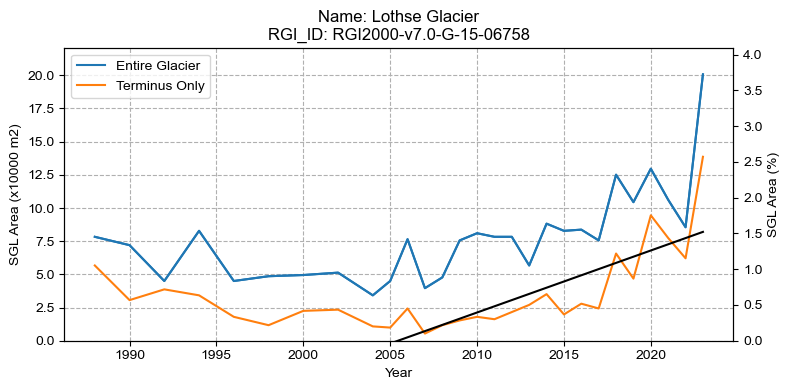

In [14]:
rgi_id = 'RGI2000-v7.0-G-15-07868' # choose which you want to provide
glacier_name = 'Loth'
plot_single_glacier(rgi_id, glacier_name)

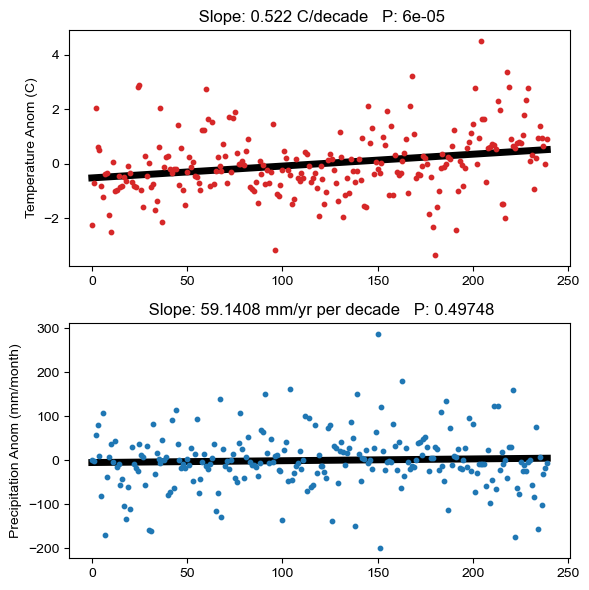

In [15]:
# get the trend in precip and temp for the same glacier
fig,axs = plt.subplots(2,1, figsize=(6,6))

xs_to_use = list(range(len(df_t_anom)))
ys_to_use = df_t_anom[rgi_id].values
p_g, slope_g, r2_g, xs_g, ys_g = regress_glacier(xs_to_use, ys_to_use)

axs[0].scatter(xs_to_use, ys_to_use, c='tab:red', s=10, zorder=2)
axs[0].plot(xs_g, ys_g, c='black', linewidth=5, zorder=1)
axs[0].set_ylabel("Temperature Anom (C)")
axs[0].set_title(f" Slope: {round(slope_g*12*10,5)} C/decade   P: {p_g}")



xs_to_use = list(range(len(df_p_anom)))
ys_to_use = df_p_anom[rgi_id].values*1000
p_g, slope_g, r2_g, xs_g, ys_g = regress_glacier(xs_to_use, ys_to_use)

axs[1].scatter(xs_to_use, ys_to_use, c='tab:blue', s=10, zorder=2)
axs[1].plot(xs_g, ys_g, c='black', linewidth=5, zorder=1)
axs[1].set_ylabel("Precipitation Anom (mm/month)")
axs[1].set_title(f" Slope: {round(slope_g*10*12 *12/365 *365,5)} mm/yr per decade   P: {p_g}")

plt.tight_layout()

In [16]:
# calculate the slope and significance of the 2004-2023 water timeseries for every glacier
years_to_use = list(range(2004,2024))

# for terminus areas of all glaciers
regression_df_terminus = []
for idx, row in df_0423_term.iterrows():
    # get the data for this row
    areas_to_use = list(row[years_to_use].values)

    p_g, slope_g, r2_g, xs_g, ys_g = regress_glacier(years_to_use, areas_to_use)
    out_df = pd.DataFrame({'rgi_id':[row['rgi_id']], 'o1_region':[row['o1_region']], 'o2_region':[row['o2_region']],
                          'slope':[slope_g], 'p':[p_g], 'r2':[r2_g], 'xs':[xs_g], 'ys':[ys_g],
                           'median':[np.nanmedian(areas_to_use)], 'mean':[np.nanmean(areas_to_use)],
                           'area_dc':[row['area_dc']]})
    regression_df_terminus.append(out_df)
regression_df_terminus = pd.concat(regression_df_terminus)

# for full glacier extent
regression_df_full = []
for idx, row in df_0423_full.iterrows():
    # get the data for this row
    areas_to_use = list(row[years_to_use].values)

    p_g, slope_g, r2_g, xs_g, ys_g = regress_glacier(years_to_use, areas_to_use)
    out_df = pd.DataFrame({'rgi_id':[row['rgi_id']], 'o1_region':[row['o1_region']], 'o2_region':[row['o2_region']],
                          'slope':[slope_g], 'p':[p_g], 'r2':[r2_g], 'xs':[xs_g], 'ys':[ys_g],
                           'median':[np.nanmedian(areas_to_use)], 'mean':[np.nanmean(areas_to_use)],
                           'area_dc':[row['area_dc']]})
    regression_df_full.append(out_df)
regression_df_full = pd.concat(regression_df_full)

In [17]:
regression_df_terminus.head(1)

,rgi_id,o1_region,o2_region,slope,p,r2,xs,ys,median,mean,area_dc
0,RGI2000-v7.0-G-13-01958,13,13-01,0.0,1.0,1.0,"[2004, 2023]","[0.0, 0.0]",0.0,0.0,1.146819


In [18]:
# lets subset to rows that have median area greater than xyz
print(len(regression_df_terminus))

df_substantial = regression_df_terminus[ (regression_df_terminus['median']>4500) ]
df_nochange = df_substantial[df_substantial['p']>0.05]
print(len(df_nochange))


df_significant = regression_df_terminus[ (regression_df_terminus['median']>4500) & (regression_df_terminus['p']<=0.05) ]
df_increasing = df_significant[df_significant['slope']>0]
df_decreasing = df_significant[df_significant['slope']<0]

rgi_increasing = df_increasing['rgi_id']
rgi_decreasing = df_decreasing['rgi_id']
rgi_nochange = df_nochange['rgi_id']

print(len(df_significant), len(df_increasing), len(df_decreasing))

750
76
93 80 13


In [19]:
# save our regression info to csv
out_path = os.path.join(folder_datasets,'glacier_sgl_trends.csv')
regression_df_terminus.to_csv(out_path, index=False)

<Axes: >

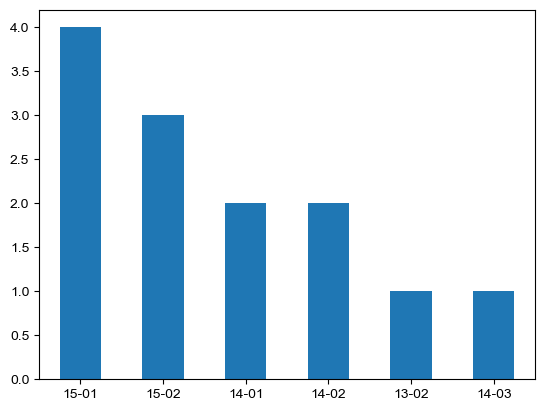

In [20]:
# plt.hist(df_decreasing['o2_region'])
df_decreasing['o2_region'].value_counts().plot.bar(rot=0)

<Axes: >

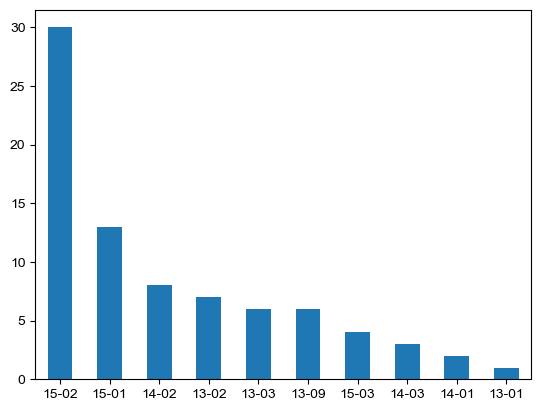

In [21]:
df_increasing['o2_region'].value_counts().plot.bar(rot=0)

(array([263.,  81.,  55.,  44.,  26.,  37.,  24.,  16.,  25., 179.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

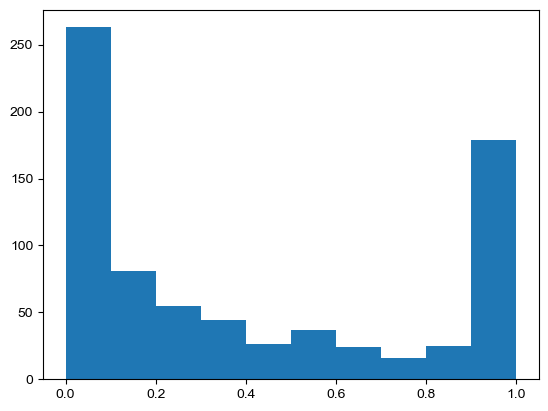

In [22]:
plt.hist(regression_df_terminus['p'])

In [23]:
areas = regression_df_terminus[regression_df_terminus['p']<0.1]['mean']
norm1 = regression_df_terminus[regression_df_terminus['p']<0.1]['area_dc']*(1000*1000)

areas

0    15030.0
0      180.0
0       90.0
0    94725.0
0    12555.0
      ...   
0     3330.0
0     2115.0
0     4455.0
0     1620.0
0     5535.0
Name: mean, Length: 263, dtype: float64

210 53


(array([11.,  9., 10., 19.,  4., 35., 68., 58., 33., 16.]),
 array([-2.70676694e-07, -2.15324027e-07, -1.59971360e-07, -1.04618692e-07,
        -4.92660251e-08,  6.08664220e-09,  6.14393095e-08,  1.16791977e-07,
         1.72144644e-07,  2.27497312e-07,  2.82849979e-07]),
 <BarContainer object of 10 artists>)

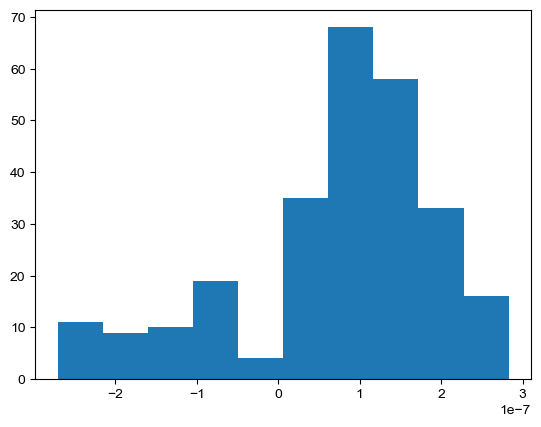

In [24]:
slopes = regression_df_terminus[regression_df_terminus['p']<0.1]['slope']
print(len(slopes[slopes>0]), len(slopes[slopes<0]) )

norm1 = regression_df_terminus[regression_df_terminus['p']<0.1]['area_dc']*(1000*1000)
norm2 = regression_df_terminus[regression_df_terminus['p']<0.1]['mean']*(1000*1000)
plt.hist(slopes/norm2)

In [25]:
# calculate the slope and significance of the 2004-2023 climate timeseries for every glacier
years_to_use = list(range(2004,2024))

# for temp, in degC/decade
regression_df_t = []
for idx, row in df_0423_term.iterrows():
    
    # get temp data
    ys_to_use = df_t_anom[row['rgi_id']].values
    xs_to_use = list(range(len(ys_to_use)))
    p_g, slope_g, r2_g, xs_g, ys_g = regress_glacier(xs_to_use, ys_to_use)
    
    out_df = pd.DataFrame({'rgi_id':[row['rgi_id']], 'o1_region':[row['o1_region']], 'o2_region':[row['o2_region']],
                          'slope':[slope_g*12*10], 'p':[p_g], 'r2':[r2_g], 'xs':[xs_g], 'ys':[ys_g],
                           'median':[np.nanmedian(areas_to_use)], 'mean':[np.nanmean(areas_to_use)],
                           'area_dc':[row['area_dc']]})
    regression_df_t.append(out_df)
regression_df_t = pd.concat(regression_df_t)

# for precip, in mm/yr / decade
regression_df_p = []
for idx, row in df_0423_term.iterrows():
    
    # get temp data
    ys_to_use = df_p_anom[row['rgi_id']].values
    xs_to_use = list(range(len(ys_to_use)))
    p_g, slope_g, r2_g, xs_g, ys_g = regress_glacier(xs_to_use, ys_to_use)
    
    out_df = pd.DataFrame({'rgi_id':[row['rgi_id']], 'o1_region':[row['o1_region']], 'o2_region':[row['o2_region']],
                          'slope':[slope_g*10*12 *12], 'p':[p_g], 'r2':[r2_g], 'xs':[xs_g], 'ys':[ys_g],
                           'median':[np.nanmedian(areas_to_use)], 'mean':[np.nanmean(areas_to_use)],
                           'area_dc':[row['area_dc']]})
    regression_df_p.append(out_df)
regression_df_p = pd.concat(regression_df_p)

In [26]:
# save to csvs
out_path = os.path.join(folder_datasets,'glacier_prec_trends.csv')
regression_df_p.to_csv(out_path, index=False)

out_path = os.path.join(folder_datasets,'glacier_temp_trends.csv')
regression_df_t.to_csv(out_path, index=False)

In [27]:
# subset to glaciers with increasing, decreasing water
regression_df_p_wi = regression_df_p[regression_df_p['rgi_id'].isin(rgi_increasing)]
regression_df_p_wd = regression_df_p[regression_df_p['rgi_id'].isin(rgi_decreasing)]

regression_df_t_wi = regression_df_t[regression_df_t['rgi_id'].isin(rgi_increasing)]
regression_df_t_wd = regression_df_t[regression_df_t['rgi_id'].isin(rgi_decreasing)]

regression_df_t_wnc = regression_df_t[regression_df_t['rgi_id'].isin(rgi_nochange)]
regression_df_p_wnc = regression_df_p[regression_df_p['rgi_id'].isin(rgi_nochange)]

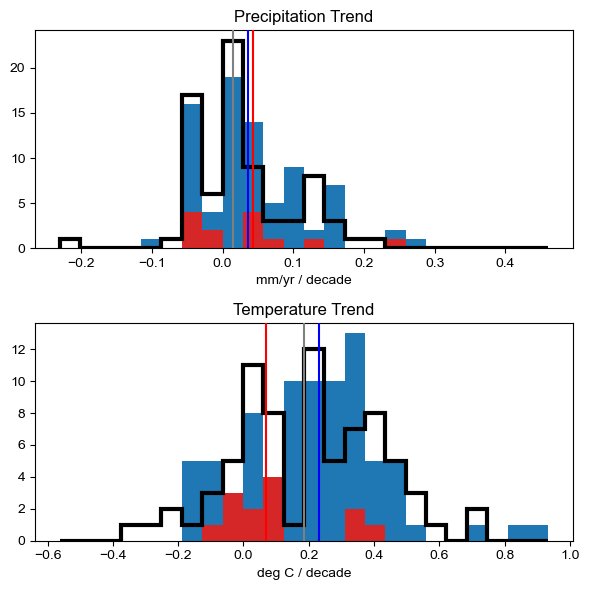

In [28]:
# plots showing differences in t/p changes in increasing/decreasing glaciers
# first increasing water
fig,axs=plt.subplots(2,1, figsize=(6,6))

# precip first
bins_to_use = np.linspace(np.nanmin(regression_df_p['slope']),np.nanmax(regression_df_p['slope']),25)

# increasing and decreasing water glaciers
axs[0].hist(regression_df_p_wi['slope'], bins=bins_to_use,
            color='tab:blue', label='Increasing SGLs')
axs[0].hist(regression_df_p_wd['slope'], bins=bins_to_use,
            color='tab:red', label='Decreasing SGLs')

# entire population on twin axis
# ax02 = axs[0].twinx()
axs[0].hist(regression_df_p_wnc['slope'], bins=bins_to_use, histtype=u'step',
            color='black', label='All', linewidth=3)

# vertical lins to show the median of each distribution
axs[0].axvline(np.nanmedian(regression_df_p_wi['slope']), color='blue', zorder=5)
axs[0].axvline(np.nanmedian(regression_df_p_wd['slope']), color='red', zorder=5)
axs[0].axvline(np.nanmedian(regression_df_p['slope']), color='grey', zorder=5)


# then temperature
bins_to_use = np.linspace(np.nanmin(regression_df_t['slope']),np.nanmax(regression_df_t['slope']),25)

axs[1].hist(regression_df_t_wi['slope'], bins=bins_to_use,
            color='tab:blue', label='Increasing SGLs')
axs[1].hist(regression_df_t_wd['slope'], bins=bins_to_use,
            color='tab:red', label='Decreasing SGLs')

# ax02 = axs[1].twinx()
axs[1].hist(regression_df_t_wnc['slope'], bins=bins_to_use, histtype=u'step',
            color='black', label='All', linewidth=3)

# vertical lins to show the median of each distribution
axs[1].axvline(np.nanmedian(regression_df_t_wi['slope']), color='blue', zorder=5)
axs[1].axvline(np.nanmedian(regression_df_t_wd['slope']), color='red', zorder=5)
axs[1].axvline(np.nanmedian(regression_df_t['slope']), color='grey', zorder=5)


axs[0].set_title("Precipitation Trend")
axs[1].set_title("Temperature Trend")

axs[0].set_xlabel("mm/yr / decade")
axs[1].set_xlabel("deg C / decade")

plt.tight_layout()